# Setup

In [3]:
import kimimaro
from cloudvolume import Skeleton
import os

import numpy as np
import kimimaro as km
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import seaborn as sns
import imageio.v3 as iio
from scipy.io import loadmat
import h5py
from cloudvolume import CloudVolume 
import re
from tqdm import tqdm
import pandas as pd
import neuroglancer
import matplotlib.pyplot as plt
import matplotlib
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new

from neuprint import skeleton as npskel
import networkx as nx


import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/efish_em/efish_em')

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest
import AnalysisCode as efish 

## Plotting style settings

In [27]:
filepath = Path('/Users/kperks/Documents/ell-connectome/efish_em')
filename = 'efish_em.mplstyle'
plt.style.use(filepath/filename)

In [28]:
cell_colors = efish.color_palette('cell')
cell_colors['uk']='#aaaaaa'
cell_colors['fov']='#aaaaaa'
cell_colors['tsd']='#aaaaaa'
cell_colors['h']='#aaaaaa'
structure_colors = efish.color_palette('structure')

# mini tutorial video

https://www.youtube.com/watch?v=tyQGQtw2WIE

# VAST .raw SEG to cloudvolume precomputed

In [6]:
# [(p*r/v) for p,r,v in zip((1226, 2282, 345), (128,128,120), (16,16,30))]

[(p*r/v) for p,r,v in zip((17415,2701,1932), (64,64,60), (16,16,30))]

[69660.0, 10804.0, 3864.0]

In [25]:
3536/2 + 17415


19183.0

##  stack .raw to hdf5 numpy array dset

In [118]:
segpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/segments/MG1_presyn_partial')
skelpath = segpath.parent.parent/ 'skeletons/MG1_presyn_partial'
rawpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/image_stacks')

h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5') #Path('/Volumes/Crucial X6/ELL_connectome_local/VAST/VAST_to_ng/h5') #Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')


In [119]:
cell_ids = ['386612701','386224676','299405462','299439953','299496636']#['299392199'] #mg1
# cell_ids = ['126649726','213605530','214581797','299404889','386426114']#,'387850816']#] # mg2


folder_list = [f'mg1_{c}_mip3_clipy' for c in cell_ids]#['SG_in-sub-vol_1-40_mip1','SG_in-sub-vol_41-89_mip1']#['386612701']]

In [120]:
skelpath / 'boundingbox_all.mat'

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/skeletons/MG1_presyn_partial/boundingbox_all.mat')

In [128]:
bbox = loadmat(skelpath / 'boundingbox_all.mat')['boundingbox']
#loadmat(segpath.parent.parent / 'skeletons/LG_presyn_labeled/lg_301787806_mip3_clipy_bbox.mat')['boundingbox']
bbox[0][1] = 13000
bbox

array([[ 3652, 13000,     1],
       [27400, 20410,  3529]], dtype=uint16)

In [129]:
(bbox[1][1]-13000)*16/128 #

926.25

In [130]:
(bbox[1][0]-bbox[0][0])*16/128

2968.5

In [131]:
'_'.join(folder_list[0].split('_')[0:3])

'mg1_386612701_mip3'

In [132]:
int(folder_list[0].split('_')[1])

386612701

In [134]:
segpath / f'{rootstr}_ID.mat'

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/segments/MG1_presyn_partial/mg1_386612701_mip3_ID.mat')

In [135]:
for cell_folder in folder_list:
    rootstr = '_'.join(cell_folder.split('_')[0:3])#cell_folder #
    matarr = loadmat(segpath / f'{rootstr}_ID.mat')['name'] #loadmat(segpath / f'Fig1_gca_spines_lf_edited_ID.mat')['name']#
    ID = [int(n[0].split('_')[0]) for n in matarr[0][1:]]#[int(folder_list[0].split('_')[1])]#
    
    # Mapping dictionary
    ID_map = {i+1: n for i, n in enumerate(ID)}
    
    # Apply mapping while keeping zeros unchanged
    vectorized_map = np.vectorize(lambda x: ID_map.get(x, x))
    
    output_file = h5path / f'{cell_folder}.h5'
    dataset_name = "volume"
    
    # Dimensions and other parameters
    mip_level = 3
    VAST_res = [30,16,16]  #(nm/px) z,y,x 
    vox_res = (120,128,128) #(30,32,32)#(120,128,128)#(nm/px) z,y,x  # (nm/px) z,y,x 
    x_box = [bbox[0][0],bbox[1][0]]
    y_box = [bbox[0][1],bbox[1][1]]
    z_box = [bbox[0][2],bbox[1][2]]
    data_type = np.uint8
    
    fullpath = rawpath / cell_folder
    raw_files = sorted(Path(fullpath).glob("*.raw"))  # Ensure files are sorted correctly
    width = int(raw_files[0].name.split('_')[-2].split('x')[0])
    height = int(raw_files[0].name.split('_')[-2].split('x')[1])
    z_slices = len(raw_files)
        
    # Create the HDF5 file
    with h5py.File(output_file, "w") as hdf:
        # Create an empty dataset with the full dimensions
        dset = hdf.create_dataset(dataset_name, 
                                  shape=(z_slices, height, width), 
                                  dtype="uint32")
        
        # Write metadata
        dset.attrs["description"] = "3D volume data"
        dset.attrs["width"] = width
        dset.attrs["height"] = height
        dset.attrs["depth"] = z_slices
        dset.attrs["res"] = vox_res
        dset.attrs["offset"] = (np.min(z_box)*VAST_res[0]/vox_res[0], 
                                np.min(y_box)*VAST_res[1]/vox_res[1], 
                                np.min(x_box)*VAST_res[2]/vox_res[2])
        dset.attrs["order"] = ('z', 'y', 'x')
        dset.attrs["mip"] = mip_level
    
        # Process and write slices one at a time
        with tqdm(total=len(raw_files)) as pbar:
            for z, file_path in enumerate(raw_files):
                pbar.update(1)
                with open(file_path, "rb") as f:
                    slice_data = np.fromfile(f, dtype="uint8").reshape((height, width))
                    slice_data = slice_data.astype(np.int32)
                    slice_data = vectorized_map(slice_data)
                    dset[z, :, :] = slice_data  # Write directly to the HDF5 dataset

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 884/884 [04:54<00:00,  3.00it/s]


In [124]:
np.unique(slice_data)
slice_data.shape

(2232, 1322)

## combine h5 files

dset must be same size (same x,y,z bounds from VAST)

In [136]:
cell_ids = ['386612701','386224676','299405462','299439953','299496636'] #mg1
# cell_ids = ['126649726','213605530','214581797','299404889','386426114']# mg2
folder_list = [f'mg1_{cid}_mip3_clipy.h5' for cid in cell_ids]
folder_list

['mg1_386612701_mip3_clipy.h5',
 'mg1_386224676_mip3_clipy.h5',
 'mg1_299405462_mip3_clipy.h5',
 'mg1_299439953_mip3_clipy.h5',
 'mg1_299496636_mip3_clipy.h5']

In [137]:
input_files = [h5path / fname for fname in folder_list]#['MG_in-sub-vol_1-6.h5','MG_in-sub-vol_7-9.h5','MG_in-sub-vol_10-12.h5']]
output_file = h5path/ "MG1_presyn_annot.h5"

In [88]:
input_files

[PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5/mg1_299392199_mip3_clipy.h5'),
 PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5/mg1_299405462_mip3_clipy.h5'),
 PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5/mg1_299439953_mip3_clipy.h5'),
 PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5/mg1_299496636_mip3_clipy.h5'),
 PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5/mg1_386224676_mip3_clipy.h5')]

In [31]:
from contextlib import ExitStack

In [138]:

with ExitStack() as stack:
    h5_files = [stack.enter_context(h5py.File(f, 'r')) for f in input_files]  # Open all input files
    # print(h5_files[0].keys)
    
    with h5py.File(output_file, 'w') as f_out:  # Create a new HDF5 file
        for dset_name in h5_files[0].keys():  # Iterate through datasets
            # print(dset_name)
            data_shape = h5_files[0][dset_name].shape
            data_dtype = h5_files[0][dset_name].dtype
            
        # Create the dataset in the new file
        combined_data = f_out.create_dataset(dset_name, shape=data_shape, dtype=data_dtype)

        # Sum data from all input files
        combined_data[:] = sum(f[dset_name][()] for f in h5_files)

        # Copy attributes
        for attr_name, attr_value in h5_files[0][dset_name].attrs.items():
            combined_data.attrs[attr_name] = attr_value

In [166]:
# ID = []
# for cell_folder in ['SG_in-sub-vol_41-89','SG_in-sub-vol_1-40']:
#     matarr = loadmat(segpath / f'{cell_folder}_ID.mat')['name']
#     ID.extend([int(n[0].split('_')[0]) for n in matarr[0][1:]])

## read h5 file 

In [140]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')
# h5path = Path('/Volumes/Crucial X6/ELL_connectome_local/VAST/VAST_to_ng/h5') 

In [141]:
cell_folder = 'MG1_presyn_annot'

In [142]:
# Define the file name and dataset name
hdf_file = h5path / f'{cell_folder}.h5'
# Open the HDF5 file in read mode
with h5py.File(hdf_file, "r") as hdf:
    # Access the dataset
    dset = hdf["volume"]
    print(dict(dset.attrs))
    
    volume = hdf["volume"][:]
    res = dset.attrs['res']
    order = dset.attrs['order']
    offset = dset.attrs['offset']


{'depth': 884, 'description': '3D volume data', 'height': 926, 'mip': 3, 'offset': array([2.500e-01, 1.625e+03, 4.565e+02]), 'order': array(['z', 'y', 'x'], dtype=object), 'res': array([120, 128, 128]), 'width': 2968}


In [ ]:
print(f'{volume.shape} in {order}')

In [48]:
np.unique(volume)

array([        0, 126649726, 213605530, 214581797, 299404889, 386426114],
      dtype=uint32)

In [188]:
collapsed = volume.sum(axis=0)

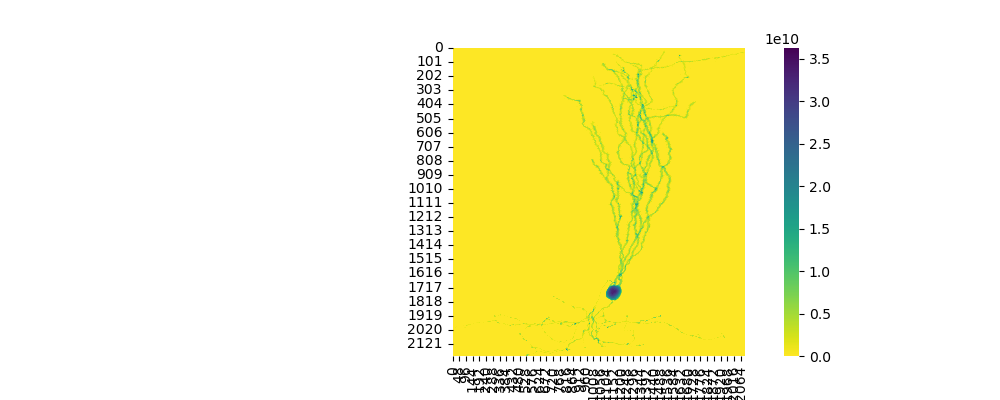

In [189]:
hfig,ax = plt.subplots(1,figsize=(10,4))
# sns.heatmap(volume[489,:,:],cmap = 'viridis_r',ax=ax)
sns.heatmap(collapsed,cmap = 'viridis_r',ax=ax)
ax.set_aspect('equal')

## create precomputed using CloudVolume

In [157]:
help(CloudVolume.from_numpy)

Help on method from_numpy in module cloudvolume.cloudvolume:

from_numpy(arr, vol_path='file:///tmp/image/jg3k0u', resolution=(4, 4, 40), voxel_offset=(0, 0, 0), chunk_size=(128, 128, 64), layer_type=None, max_mip=0, encoding='raw', compress=None, progress=False, encoding_level=None, encoding_effort=None) method of builtins.type instance
    Create a new dataset from a numpy array.
    
    max_mip: (int) the maximum mip level id in the info file. 
    Note that currently the numpy array can only sit in mip 0,
    the max_mip was only created in info file.
    the numpy array itself was not downsampled.



### note can do with igneous

(ell-kimimaro) kperks@Kristas-Mac-mini VAST_to_ng % igneous image --help     
Usage: igneous image [OPTIONS] COMMAND [ARGS]...

  Manipulate image volumes. (subgroup)

  Images are the base datastructure in Neuroglancer. This subgroup offers
  methods for downsampling, transfers, reencoding, rechunking, sharding, and
  contrast correction.

Options:
  --help  Show this message and exit.

Commands:
  ccl         Perform connected components labeling on the image.
  contrast    Perform contrast correction on the image.
  create      Create a Precomputed volume from another data source.
  downsample  Create an image pyramid for grayscale or labeled images.
  reorder     Re-arrange z-slices.
  rm          Delete the image layer of a dataset.
  roi         Computes bounding box of non-empty image regions.
  voxels      Compute voxel counts per label.
  xfer        Copy, re-encode, or shard an image layer.
(ell-kimimaro) kperks@Kristas-Mac-mini VAST_to_ng % igneous image create --help
Usage: igneous image create [OPTIONS] SRC DEST

  Create a Precomputed volume from another data source.

  Supports: .npy files, .h5/.hdf5 files, and .ckl files

  Hopefully will support others such as TIFF in the future.

Options:
  --resolution TUPLE3        Resolution of the volume in nanometers along x,y,
                             and z dimensions.  [default: 1, 1, 1]
  --offset TUPLE3            Voxel offset in x,y, and z.  [default: 0, 0, 0]
  --seg                      Sets layer type to segmentation (default image).
  --encoding ENCODING        Which image encoding to use. Options: [all] raw,
                             png; [images] jpeg, jpegxl (jxl); [segmentations]
                             compressed_segmentation (cseg), compresso (cpso),
                             crackle (ckl); [floats] fpzip, kempressed, zfpc
                             [default: raw]
  --encoding-level TEXT      For some encodings (png level, jpeg & jpeg xl
                             quality, fpzip precision) a simple scalar value
                             can adjust the compression efficiency.
  --encoding-effort INTEGER  (JPEG XL) Set effort (1-10) used by JPEG XL to
                             hit the quality target.  [default: 5]
  --compress COMPRESS        Set the image compression scheme. Options:
                             'none', 'gzip', 'br'  [default: br]
  --chunk-size TUPLE3        Chunk size of new layers. e.g. 128,128,64
                             [default: 128, 128, 64]
  --h5-dataset TEXT          Which h5 dataset to acccess (hdf5 imports only).
                             [default: main]
  --help                     Show this message and exit.


In [45]:
# cell_folder = 'MG1_presyn_annot'

In [53]:
h5path.parent / f'precomputed/{cell_folder}'

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/precomputed/MG2_presyn_annot')

In [143]:
# Define the output directory for the precomputed volume
output_dir = h5path.parent / f'precomputed/{cell_folder}'

axis_order = [np.where(order == axis)[0][0] for axis in ['x','y','z']]

# Create a CloudVolume object from the NumPy array
vol = CloudVolume.from_numpy(
    np.transpose(volume, axes=axis_order),#volume.T,
    vol_path=str(output_dir),
    voxel_offset=[offset[i] for i in axis_order],#(256,928, 64),
    resolution=[res[i] for i in axis_order],#(256, 256, 240),  # Example: 4x4x40 nm voxel size
    layer_type='segmentation',     # For image data; use 'segmentation' for label data
    max_mip=0
)

# # Save the volume
# vol.commit()  # Writes data to the specified directory
# print("Volume saved to:", output_dir)

In [192]:
volume.T.shape

(2096, 2208, 884)

# import raw EM from VAST into numpy array

from image_stacks folder, run `python stack_to_volume.py`

In [908]:
rawpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/image_stacks')

cell_folder = 'EM_mip2'

In [909]:
fullpath = rawpath / cell_folder
raw_files = sorted(list(fullpath.glob('*.raw')))

In [910]:
raw_files[0]

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/image_stacks/EM_mip2/ELL_export_s0000_8064x8192_8bpp.raw')

In [911]:
len(raw_files)

992

In [380]:
# Define parameters
width = int(raw_files[0].name.split('_')[-2].split('x')[0])
height = int(raw_files[0].name.split('_')[-2].split('x')[1])
data_type = np.uint8

# Read all slices and stack into a 3D array
slices = []
for file_name in raw_files:
    file_path = rawpath / file_name
    with open(file_path, "rb") as f:
        slice_data = np.fromfile(f, dtype=data_type).reshape((height, width))
        
        slices.append(slice_data)

# Stack slices along the z-axis
volume = np.stack(slices, axis=0)

print(f'{volume.shape} in z,y,x')



(884, 4096, 4032) in z,y,x


In [381]:
volume.shape

(884, 4096, 4032)

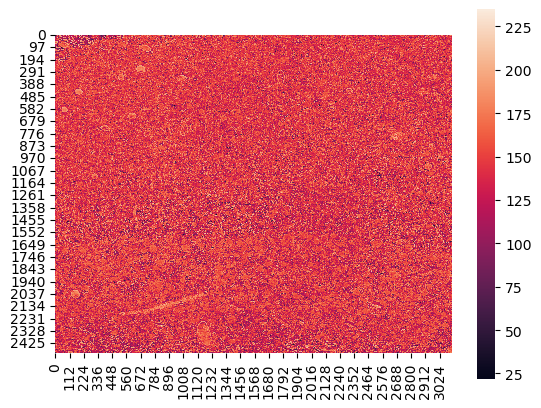

In [264]:
h = sns.heatmap(volume[0,:,:])
ax = plt.gca()
ax.set_aspect('equal')

## export volume to h5

part of `ptyhon stack_to_volume`

In [382]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')

In [383]:
x_box = [0]
y_box = [0]
z_box = [0]

vox_res = (60,64,64) #(nm/px) z,y,x

In [384]:
# Define the file name and dataset name
output_file = h5path / f'{cell_folder}.h5'
dataset_name = "volume"  # You can name the dataset as you like

with h5py.File(output_file, "w") as hdf:
    dset = hdf.create_dataset(dataset_name, data=volume)
    dset.attrs["description"] = "3D volume data"
    dset.attrs["width"] = volume.shape[2]
    dset.attrs["height"] = volume.shape[1]
    dset.attrs["depth"] = volume.shape[0]
    dset.attrs["res"] = vox_res # for mip4
    dset.attrs["offset"] =(np.min(z_box)*30/vox_res[0],np.min(y_box)*16/vox_res[1],np.min(x_box)*16/vox_res[2])
    dset.attrs["order"] = ('z','y','x')
    dset.attrs["mip"] = 2

print(f"Data saved to {output_file}")

Data saved to /Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5/EM_mip3.h5


## read h5 file 

In [925]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')

In [926]:
cell_folder = 'EM_mip3'

In [922]:
# Define the file name and dataset name
hdf_file = h5path / f'{cell_folder}.h5'
# Open the HDF5 file in read mode
with h5py.File(hdf_file, "r") as hdf:
    # Access the dataset
    dset = hdf["volume"]
    print(dict(dset.attrs))
    volume = hdf["volume"][:]
    res = dset.attrs['res']
    order = dset.attrs['order']
    offset = dset.attrs['offset']


{'depth': 884, 'description': '3D volume data', 'height': 4096, 'mip': 3, 'offset': array([0., 0., 0.]), 'order': array(['z', 'y', 'x'], dtype=object), 'res': array([120, 128, 128]), 'width': 4032}


In [21]:
volume.shape

(884, 2208, 2096)

In [924]:
volume.T.shape

(4032, 4096, 884)

## create precomputed using CloudVolume

In [38]:
help(CloudVolume.from_numpy)

Help on method from_numpy in module cloudvolume.cloudvolume:

from_numpy(arr, vol_path='file:///tmp/image/5pwujk', resolution=(4, 4, 40), voxel_offset=(0, 0, 0), chunk_size=(128, 128, 64), layer_type=None, max_mip=0, encoding='raw', compress=None, progress=False) method of builtins.type instance
    Create a new dataset from a numpy array.
    
    max_mip: (int) the maximum mip level id in the info file. 
    Note that currently the numpy array can only sit in mip 0,
    the max_mip was only created in info file.
    the numpy array itself was not downsampled.



In [389]:
# Define the output directory for the precomputed volume
output_dir = h5path.parent / f'precomputed/{cell_folder}'

axis_order = [np.where(order == axis)[0][0] for axis in ['x','y','z']]

# Create a CloudVolume object from the NumPy array
vol = CloudVolume.from_numpy(
    volume.T,
    vol_path=str(output_dir),
    voxel_offset=[offset[i] for i in axis_order],#(256,928, 64),
    resolution=[res[i] for i in axis_order],#(256, 256, 240),  # Example: 4x4x40 nm voxel size
    layer_type='image',     # For image data; use 'segmentation' for label data
    max_mip=0
)

# # Save the volume
# vol.commit()  # Writes data to the specified directory
# print("Volume saved to:", output_dir)

In [ ]:
volume.shape

### CHUNKED

In [3]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')

In [4]:
cell_folder = 'EM_mip2'

In [8]:
hdf_file = h5path / f'{cell_folder}.h5'
chunk_depth = 10  # Number of slices to process at a time
# z_slices, height, width = dset.shape

with h5py.File(hdf_file, "r") as hdf:
    dset = hdf["volume"]
    print(dset.shape)
    z_slices, height, width = dset.shape
    res = dset.attrs["res"]
    order = dset.attrs["order"]
    offset = dset.attrs["offset"]

    axis_order = [np.where(order == axis)[0][0] for axis in ["x", "y", "z"]]

    # Define the output directory
    output_dir = h5path.parent / f"precomputed/{cell_folder}"
    vol = CloudVolume.from_numpy(
        np.zeros((width, height, z_slices), dtype="uint8"),  # Initialize metadata
        vol_path=str(output_dir),
        voxel_offset=[offset[i] for i in axis_order],
        resolution=[res[i] for i in axis_order],
        layer_type="image",  # Use 'segmentation' for label data
        max_mip=0,
        compress=True
    )

(992, 8192, 8064)


In [7]:
vol

In [ ]:
with h5py.File(hdf_file, "r") as hdf:
    dset = hdf["volume"]
    print(dset.shape)
    z_slices, height, width = dset.shape
    res = dset.attrs["res"]
    order = dset.attrs["order"]
    offset = dset.attrs["offset"]

    axis_order = [np.where(order == axis)[0][0] for axis in ["x", "y", "z"]]
    # Write data in chunks
    # z_slices=50
    for z_start in range(0, z_slices, chunk_depth): #
        z_end = min(z_start + chunk_depth, z_slices)  # Ensure the last chunk fits
        
        print(f"Processing slices {z_start} to {z_end - 1}")

        # Read chunk from HDF5
        chunk = dset[z_start:z_end, :, :]
        print(chunk.shape)

        # Transpose to Neuroglancer format (x, y, z)
        chunk = np.transpose(chunk, axes=(2, 1, 0))

        # Write chunk to Neuroglancer
        vol[
            :, :, z_start:z_end
        ] = chunk #.T  # Transpose to Neuroglancer's (x, y, z) order

# Command line tasks

## queue

In [ ]:
# pqt status ./queue # checks status of queue

# igneous execute -x ./queue # -x flag exits when done with all tasks

## downsampling

In [ ]:
# igneous image downsample ./precomputed/test_em --queue ./queue # run from VAST_to_ng folder; creates queue directory in VAST_to_ng folder if does not exist)



## mesh

---
igneous mesh --help  
Usage: igneous mesh [OPTIONS] COMMAND [ARGS]...  
  
  Create 3D meshes from a segmentation. (subgroup)  
  
  Meshing is a two step process of forging then  merging. First the meshes are
  created from a regular grid of segmentation cutouts. Second, the pieces are
  glued together.  
  
Options:  
  --help  Show this message and exit.  
  
Commands:  
  **clean**          Removes temporary files.  
  **forge**          (1) Synthesize meshes from segmentation cutouts.  
  **merge**          (2) Merge the mesh pieces produced from the forging step.  
  **merge-sharded**  (2) Postprocess fragments into finished sharded multires...  
  **rm**             Delete mesh files.  
  **spatial-index**  (subgroup) Create or download mesh spatial indices.  
  **xfer**           Transfer meshes to another location.  

---

Two-step process: first forge (creates mesh for each section of the image -- marching cubes simplification with edges set up for merge), second merge ()

In [ ]:
# igneous mesh forge [cell_folder] --mip 0 --queue ./queue
# igneous execute -x ./queue    
# igneous mesh merge sg2_387415866_crude_mip3 --queue ./queue
# igneous execute -x ./queue    

## skeleton

igneous skeleton --help    
Usage: igneous skeleton [OPTIONS] COMMAND [ARGS]...  

  Create skeletons from a segmentation.  
 
  Skeletonizing is a two step process of forging  then merging. First the
  skeletons are created from a regular grid of segmentation cutouts. Second,
  the pieces are postprocessed and glued together.  

Options:  
  --help  Show this message and exit.  

Commands:  
  **clean**          Removes temporary files.  
  **forge**          (1) Synthesize skeletons from segmentation cutouts.  
  **merge**          (2) Postprocess fragments into finished skeletons.  
  **merge-sharded**  (2) Postprocess fragments into finished skeletons.  
  **rm**             Delete skeleton files.  
  **spatial-index**  (subgroup) Create or download mesh spatial indices.  
  **xfer**           Transfer skeletons to another location.  

igneous skeleton forge --help  
Usage: igneous skeleton forge [OPTIONS] PATH  

  (1) Synthesize skeletons from segmentation cutouts.  

  A large labeled image is divided into a regular grid. Kimimaro is applied to
  grid point, which performs a TEASAR based skeletonization.  

  You can read more about the parameters here: https://github.com/seung-lab/kimimaro  

  Tutorials are located here:  

  - https://github.com/seung-lab/kimimaro/wiki/A-Pictorial-Guide-to-TEASAR-Skeletonization  

  - https://github.com/seung-lab/kimimaro/wiki/Intuition-for-Setting-Parameters-const-and-scale  

  A guide to how much this might cost is located here:  
 
  - https://github.com/seung-lab/kimimaro/wiki/The-Economics:-Skeletons-for-the-People  

Options:  
  --queue TEXT                    AWS SQS queue or directory to be used for atask queue. e.g. sqs://my-queue or ./my-queue. See https://github.com/seung-lab/python-task-queue  
  --mip INTEGER                   Perform skeletonizing using this level of
                                  the image pyramid.  [default: 0]  
  --shape TUPLE3                  Set the task shape in voxels.  [default:
                                  512, 512, 512]  
  --fill-missing                  Interpret missing image files as background
                                  instead of failing.  
  --fix-branching                 Trades speed for quality of branching at
                                  forks.  [default: True]  
  --fix-borders                   Allows trivial merging of single voxel
                                  overlap tasks. Only switch off for datasets
                                  that fit in a single task.  [default: True]  
  --fix-avocados                  Fixes somata where nuclei and cytoplasm have
                                  separate segmentations.  
  --fix-autapses                  (graphene only) Fixes autapses by using the
                                  PyChunkGraph.  
  --fill-holes                    Preprocess each cutout to eliminate
                                  background holes and holes caused by
                                  entirely contained inclusions. Warning: May
                                  remove labels that are considered
                                  inclusions.  
  --dust-threshold INTEGER        Skip skeletonizing objects smaller than this
                                  number of voxels within a cutout.  [default:
                                  1000]  
  --dust-global / --dust-local    Use global voxel counts for the dust
                                  threshold (when >0). To use this feature you
                                  must first compute the global voxel counts
                                  using the `igneous image voxels` command.
                                  [default: dust-local]    
  --spatial-index / --skip-spatial-index
                                  Create the spatial index.  [default:
                                  spatial-index]  
  --scale FLOAT                   Multiplies invalidation radius by distance
                                  from boundary.  [default: 4]  
  --const FLOAT                   Adds constant amount to invalidation radius
                                  in physical units.  [default: 10]  
  --soma-detect FLOAT             Consider objects with peak distances to
                                  boundary larger than this soma candidates.
                                  Physical units.  [default: 1100]  
  --soma-accept FLOAT             Accept soma candidates over this threshold
                                  and perform a one-time spherical
                                  invalidation around their peak value.
                                  Physical units.  [default: 3500]  
  --soma-scale FLOAT              Scale factor for soma invalidation.
                                  [default: 1.0]  
  --soma-const FLOAT              Const factor for soma invalidation.
                                  [default: 300]  
  --max-paths FLOAT               Abort skeletonizing an object after this
                                  many paths have been traced.  
  --sharded                       Generate shard fragments instead of
                                  outputing skeleton fragments.  
  --labels TUPLEN                 Skeletonize only this comma separated list
                                  of labels.  
  --cross-section INTEGER         Compute the cross sectional area for each
                                  skeleton vertex. May add substantial
                                  computation time. Integer value is the
                                  normal vector rolling average smoothing
                                  window over vertices. 0 means off.
                                  [default: 0]  
  -o, --output CLOUDPATH          Output the results to a different place.  
  --timestamp INTEGER             (graphene) Use the proofreading state at
                                  this UNIX timestamp.  
  --root-ids CLOUDPATH            (graphene) If you have a materialization of
                                  graphene root ids for this timepoint, it's
                                  more efficient to use it than making
                                  requests to the graphene server.  
  --help                          Show this message and exit.  


igneous skeleton forge [cell_folder] --mip 0 --queue ./queue

with parameters for TEASER tweaked

igneous skeleton forge MG2_presyn_annot --mip 0 --scale 25 --const 5 --soma-scale 3 --soma-detect 3000 --soma-accept 4500 --queue ./queue
igneous skeleton forge MG1_presyn_annot --mip 0 --scale 25 --const 5 --soma-scale 3 --soma-detect 3000 --soma-accept 4500 --queue ./queue

igneous skeleton forge sg2_387415866_crude_mip3 --mip 0 --dust-threshold 250 --scale 10 --const 50 --soma-scale 3 --soma-detect 3000 --soma-accept 5000 --queue ./queue
igneous skeleton forge sg2_387415866_crude_mip3 --mip 0 --scale 10 --const 50 --soma-scale 5 --soma-detect 5000 --soma-accept 7000 --queue ./queue

--mip 0 --dust-threshold 250 --scale 50 --const 100 --soma-scale 3 --soma-detect 3000 --soma-accept 4500 --queue ./queue

igneous execute -x ./queue   
igneous skeleton merge sg2_387415866_crude_mip3 --queue ./queue
igneous execute -x ./queue   

In [71]:
# igneous skeleton merge [cell_folder] --queue ./queue

# CloudVolume precomputed to swc

In [27]:
[p*r/v for p,r,v in zip((1831, 1221, 470),(128,128,120),(16,16,30))]

[14648.0, 9768.0, 1880.0]

In [175]:
vol = CloudVolume('precomputed://http://localhost:8001')

In [176]:
segIDs_all = vol.unique(bbox=vol.bounds) - set([0]) # get all segment IDs in volume and remove segment ID 0, which is background

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 595/595 [00:03<00:00, 182.47it/s]


In [178]:
segIDs_all

{299405462, 299439953, 299496636, 386224676, 386612701}

In [208]:
cid = 386612701
skel = vol.skeleton.get(cid)#(301787806)#(299405462)#(393325331)
# ['299392199','299405462']


In [ ]:
skel.components()

## view skeleton

In [145]:
%matplotlib widget

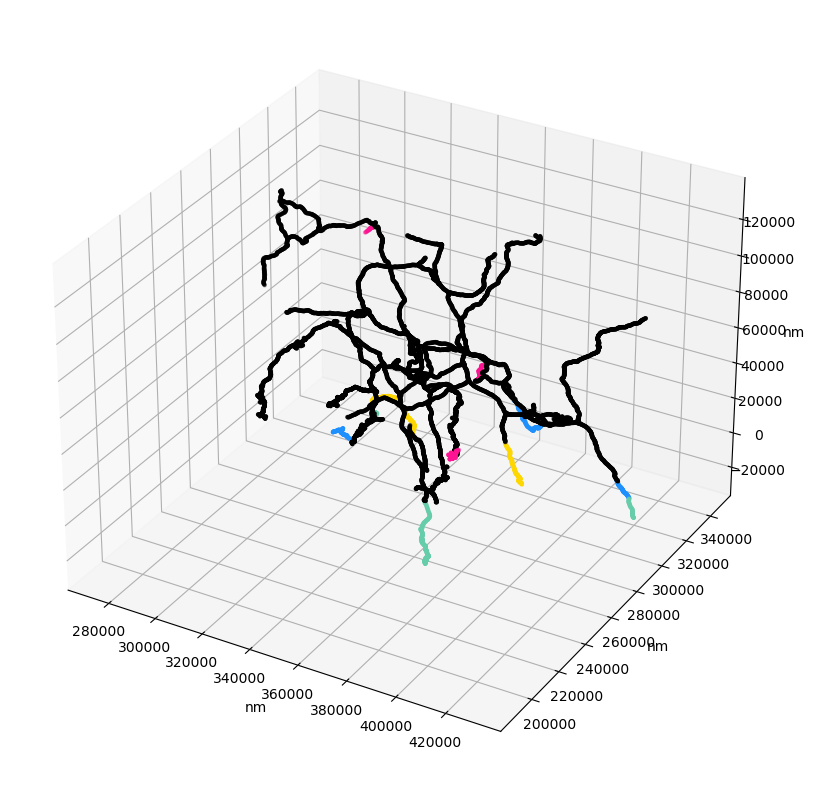

In [209]:
# skel.viewer(draw_edges=False)#(color_by='component',draw_edges=False)
skel.viewer(color_by='component',draw_edges=False)

## merge skeleton components using kimimaro

In [101]:
skel_merged = kimimaro.join_close_components(skel.components(), radius=1500)

In [102]:
skel_merged.components()

[Skeleton(segid=299392199, vertices=(shape=8953, float32), edges=(shape=8952, uint32), radius=(8953, float32), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])]

## use only the one largest component from skel

In [210]:
maxind = np.argmax([len(c.vertices) for c in skel.components()])

In [211]:
skel = skel.components()[maxind]

## use multiple hand-picked components from skel

In [128]:
skel = skel.components()[0].merge(skel.components()[2])

In [16]:
# for i, skel in enumerate(skel.components()):
#   with open('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/segments/VAST_to_ng/swc/' + str(skel.id) + '-' + str(i) + '.swc', 'wt') as f:
#     f.write(skel.to_swc())

## export skeleton to swc

In [212]:
skel.components()

[Skeleton(segid=386612701, vertices=(shape=11724, float32), edges=(shape=11723, uint32), radius=(11724, float32), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])]

In [191]:
swc_outfile = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc')

In [213]:
cell_folder = f'mg2_{cid}_mip3_clipy' #'lg_301787806_mip3'
cell_folder

'mg2_386612701_mip3_clipy'

In [214]:
# Step 4: Write the SWC data to a file
with open(swc_outfile / f'{cell_folder}.swc', 'w') as swc_file:
    swc_file.write(skel.to_swc())

In [71]:
swc_outfile / f'{cell_folder}.swc'

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc/mg2_386426114_mip3_clipy.swc')

# Apical Branch Length

In [63]:
folder_path = Path("/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/volume_subsample_sg-mg-out_ratio")
df_segments = pd.read_csv(folder_path / 'df_segments_assigned.csv')

In [64]:
dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network')
df_type= pd.read_csv(dirpath / 'metadata/df_type_auto_typed.csv')

In [ ]:
'SG_in-sub-vol'
'MG_in-sub-vol'
'OUTPUT_in-sub-vol'

In [8]:
def create_bins(boundaries):
    bins = []
    for i in range(len(boundaries) - 1):
        bins.append((boundaries[i], boundaries[i + 1]))
    return bins
    

In [14]:
vol = CloudVolume('precomputed://http://localhost:8003',progress=False)

In [15]:
# HOW GET NUMBER OF SEGMENTS IN PRECOMPUTED TO LOOP THROUGH THEM?

In [16]:
segIDs_all = vol.unique(bbox=vol.bounds) - set([0]) # get all segment IDs in volume and remove segment ID 0, which is background

KeyboardInterrupt: 

In [ ]:
seglist = list(segIDs_all)

In [42]:
df_result= pd.DataFrame()

In [23]:
density_sg = np.asarray([20,20,20,20,20,20])/10
density_mg = np.asarray([53.000000,95.647059,113.352941,113.388889,88.187500,50.958333])/10
density_out = np.asarray([38.647059,55.360000,64.944444,74.555556,63.800000,70.000000])/10

In [66]:
spd = density_out

In [76]:
# seglist = [386392158,213590737]# MG 
# seglist = list(segIDs_all)
# seglist = [128879866,214627855,128849661] # mature SG
# seglist = [4,2,6]

mol_bounds = [1000, 3000, 5000, 7000, 9000, 12000,14000]
bins = create_bins(mol_bounds)


for seg in seglist:
    skel = vol.skeleton.get(seg)
    
    swc = skel.to_swc()
    
    df = npskel.skeleton_swc_to_df(swc)
    
    # change positions to 16nm segmentation scale(because that is the resolution in which y positions are marked)
    df['y'] = -(df['y']/16 - (16210)) # offset y position like do for spine density analysis
    df['x'] = df['x']/16
    df['z'] = df['z']/30
    vox_to_nm = 16 # to transform distance back into nm later
    
    d_total = []
    sp_total = []
    for i,b in enumerate(bins):
        mask = (df['y']>b[0]) & (df['y']<b[1])
        G = npskel.skeleton_df_to_nx(df[mask], with_attributes=True, directed=True, with_distances=True, virtual_roots=True)
        distance=nx.get_edge_attributes(G,'distance')
        d_total.append(sum(filter(lambda x: x != float('inf'), np.asarray(list(distance.values()))))*vox_to_nm/1000)
        sp_total.append(d_total[i]*spd[i])

    df_ = pd.DataFrame({
        'depth' : bins,
        'labels' : ['d0', 'd1', 'd2', 'd3', 'd4','d5'],
        'dx_total' : d_total,
        'sp_total' : sp_total
        # 'seg' : seg        
    })
    df_['seg']=seg
    df_['ctype'] = df_type[df_type['id'].isin([seg])]['cell_type'].values[0]
    df_result = pd.concat([df_result,df_],ignore_index=True)

In [78]:
df_result.to_csv(Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/volume_subsample_sg-mg-out_ratio')/'df_spine_estimates_sg_mg_out.csv')

In [65]:
df_result = pd.read_csv(Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/volume_subsample_sg-mg-out_ratio')/'df_spine_estimates_sg_mg_out.csv')
df_result.drop(columns = ['Unnamed: 0'],inplace=True)

In [66]:
ctype = [df_type[df_type['id'].isin([int(r['seg'])])]['cell_type'].values[0] for i,r in df_result.iterrows()]

df_result['ctype']=ctype

In [67]:
df_result.loc[df_result['ctype'].isin(['sg1','sg2']),'class'] = 'sg'
df_result.loc[df_result['ctype'].isin(['mg1','mg2']),'class'] = 'mg'
df_result.loc[df_result['ctype'].isin(['lg','lf']),'class'] = 'output'

In [68]:
df_result.head()

,depth,labels,dx_total,sp_total,seg,ctype,class
0,"(1000, 3000)",d0,76.504642,405.474600,559381249,sg2,sg
1,"(3000, 5000)",d1,44.258340,423.318003,559381249,sg2,sg
2,"(5000, 7000)",d2,40.813522,462.633272,559381249,sg2,sg
3,"(7000, 9000)",d3,0.000000,0.000000,559381249,sg2,sg
4,"(9000, 12000)",d4,0.000000,0.000000,559381249,sg2,sg


In [69]:
df_result[['class','sp_total']].groupby('class').describe()

sp_total                                                           \
          count         mean          std  min          25%          50%   
class                                                                      
mg         60.0  2449.374936  1864.257145  0.0  1137.197071  2088.967792   
output     36.0  1088.156798   751.840288  0.0   605.215192   998.775013   
sg        546.0    93.302551   189.125551  0.0     0.000000     0.900128   

                                  
                75%          max  
class                             
mg      3445.459941  7895.140431  
output  1565.802073  2921.642483  
sg       147.731667  2064.206418

In [58]:
546/6


91.0

In [57]:
df_result[['class','sp_total']].groupby('class').sum()

,sp_total
class,
mg,146962.496155
output,39173.644740
sg,50943.193103


In [49]:
df_result[['class','sp_total']].groupby('class').sum().div(df_result[['class','sp_total']].groupby('class').sum().sum())

,sp_total
class,
mg,0.619887
output,0.165234
sg,0.214878


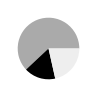

In [52]:
df_pie = pd.DataFrame.from_dict({'class':['MG','output','SG'],
                                 'spines':[146962,39173,50943]},orient='columns')

class_colors = {
    'output':'#000000',
    'MG':'#aaaaaa',
    'SG':'#eeeeee'
}

plt.figure(figsize=(1,1))
ax = plt.gca()
plt.pie(df_pie['spines'], colors=[class_colors[key] for key in df_pie['class']], 
                      wedgeprops=dict(edgecolor='none'),
                      startangle=0)
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig('/Users/kperks/Downloads/spine_count_total_pie_all.svg', format='svg', transparent=True)

In [42]:
[d *16/1000 for d in [1000, 3000, 5000, 7000, 9000, 12000,14000]]

[16.0, 48.0, 80.0, 112.0, 144.0, 192.0, 224.0]

In [41]:
np.asarray(mol_bounds) * 16/1000

array([ 16.,  48.,  80., 112., 144., 192., 224.])

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_24013/3476063936.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])


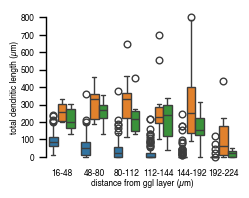

In [45]:
fig, ax = plt.subplots(figsize=(2.5, 2))
sns.boxplot(data = df_result,x = 'labels', y = 'dx_total',hue='class',legend=False)
ax.set_ylabel('total dendritic length (µm)') # this needs to match diff between ylims
ax.set_xlabel('distance from ggl layer (µm)')

ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)

plt.savefig(f'/Users/kperks/Downloads/dendritic_length.svg')

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_24013/3671181971.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])


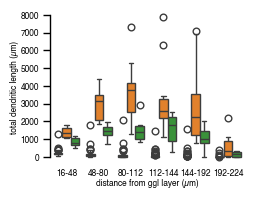

In [51]:
fig, ax = plt.subplots(figsize=(2.5, 2))
sns.boxplot(data = df_result,x = 'labels', y = 'sp_total',hue='class',legend=False)
ax.set_ylabel('total dendritic length (µm)') # this needs to match diff between ylims
ax.set_xlabel('distance from ggl layer (µm)')

ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)

plt.savefig(f'/Users/kperks/Downloads/spine_count.svg')

In [24]:
mask = df_result['ctype'].isin(['sg1','sg2'])

In [25]:
length_sg = df_result[mask].groupby('labels')['dx_total'].median().values

In [26]:
density_sg * length_sg

array([172.99666992,  95.46266547,  47.09790552,   0.        ,
         0.        ,   0.        ])

In [27]:
sum(density_sg * length_sg)

315.5572409057617

In [28]:
df_result[mask].groupby('labels')['sp_total'].median().sum()

316.7635934753418

In [39]:
df_length_total = df_result.groupby(['seg','ctype'])['dx_total'].sum().reset_index()

In [33]:
df_length_total[df_length_total['ctype'].isin(['lg','lf'])]['sp_total'].describe()

count        6.000000
mean      6528.940790
std       2676.401633
min       2996.550842
25%       4571.932315
50%       6874.125258
75%       8116.349788
max      10093.884084
Name: sp_total, dtype: float64

In [48]:
df_length_total[['ctype','dx_total']].groupby('ctype').describe()

dx_total                                                     \
         count         mean         std          min          25%   
ctype                                                               
lf         1.0  1388.492362         NaN  1388.492362  1388.492362   
lg         5.0  1043.005380  445.008928   554.683107   687.505745   
mg1        5.0  1727.328688  705.114673   966.697862  1372.232271   
mg2        5.0  1509.182858  798.630845   760.961253  1056.590241   
sg1       65.0   218.665898  223.946752     9.186424    96.431604   
sg2       26.0   288.190853  264.255745    10.422221   117.416719   

                                              
               50%          75%          max  
ctype                                         
lf     1388.492362  1388.492362  1388.492362  
lg     1113.729750  1181.107661  1678.000635  
mg1    1569.440288  1890.788360  2837.484658  
mg2    1312.762926  1586.568565  2829.031305  
sg1     168.225168   230.773726  1185.597056  
sg2     207.508022   376.111018   997.253692

<AxesSubplot:xlabel='dx_total', ylabel='Count'>

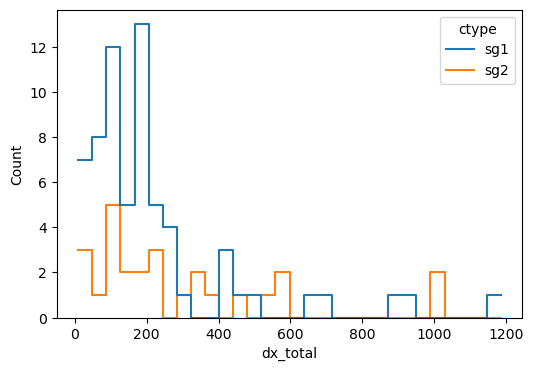

In [44]:

hfig,ax = plt.subplots(1,figsize=(6,4))
sns.histplot(data=df_length_total[df_length_total['ctype'].isin(['sg1','sg2'])],x='dx_total',bins=30,hue='ctype',element='step',fill=False)

<AxesSubplot:xlabel='dx_total', ylabel='Count'>

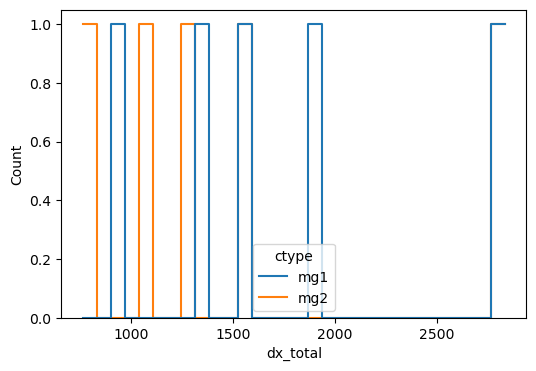

In [45]:

hfig,ax = plt.subplots(1,figsize=(6,4))
sns.histplot(data=df_length_total[df_length_total['ctype'].isin(['mg1','mg2'])],x='dx_total',bins=30,hue='ctype',element='step',fill=False)

In [30]:
df_sp_total = df_result.groupby(['seg','ctype'])['sp_total'].sum().reset_index()

<AxesSubplot:xlabel='sp_total', ylabel='Count'>

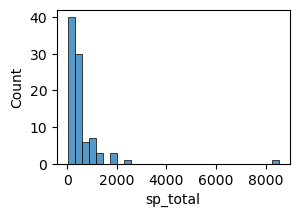

In [50]:
hfig,ax = plt.subplots(1,figsize=(3,2))
sns.histplot(data=df_sp_total[df_sp_total['ctype'].isin(['sg1','sg2'])],x='sp_total',bins=30)#,hue='ctype')

In [32]:
df_sp_total[df_sp_total['ctype'].isin(['lg','lf'])].sort_values('sp_total')

,seg,ctype,sp_total
0,128770984,lg,2996.550842
47,303969144,lg,3977.940399
43,301727988,lg,6353.908063
5,132205966,lg,7394.342454
75,393325331,lf,8357.018899
36,300474334,lg,10093.884084


In [33]:
df_sp_total[df_sp_total['ctype'].isin(['lg','lf'])]['sp_total'].describe()

count        6.000000
mean      6528.940790
std       2676.401633
min       2996.550842
25%       4571.932315
50%       6874.125258
75%       8116.349788
max      10093.884084
Name: sp_total, dtype: float64

In [51]:
df_sp_total[df_sp_total['ctype'].isin(['mg1','mg2'])].sort_values('sp_total')

,seg,ctype,sp_total
80,472361842,mg2,6562.000402
78,472282894,mg1,7555.429095
93,475781099,mg2,9710.357212
79,472284925,mg2,11612.597027
33,299439953,mg1,12716.662398
32,299392199,mg1,14338.213946
54,386392158,mg2,14783.086479
31,298228381,mg1,16368.271840
10,213590737,mg1,25433.826782
58,386426114,mg2,27882.050973


In [35]:
df_sp_total[df_sp_total['ctype'].isin(['mg1','mg2'])]['sp_total'].describe()

count       10.000000
mean     14696.249616
std       7051.685687
min       6562.000402
25%      10185.917166
50%      13527.438172
75%      15971.975500
max      27882.050973
Name: sp_total, dtype: float64

In [36]:
df_sp_total[df_sp_total['ctype'].isin(['sg1','sg2'])].sort_values('sp_total')

,seg,ctype,sp_total
74,392102325,sg1,18.372848
77,394439668,sg2,20.844442
50,308626960,sg2,24.769080
82,473460724,sg1,25.771118
99,479232204,sg2,30.710942
...,...,...,...
11,214627855,sg1,1818.201811
3,128849661,sg1,1825.735452
4,128879866,sg2,1994.507383
53,386363638,sg1,2371.194112


In [37]:
df_sp_total[df_sp_total['ctype'].isin(['sg1','sg2'])]['sp_total'].describe()

count      91.000000
mean      559.815309
std       960.244533
min        18.372848
25%       204.664536
50%       350.488183
75%       504.482460
max      8542.236951
Name: sp_total, dtype: float64

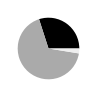

In [58]:
df_pie = pd.DataFrame.from_dict({'ctype':['output','MG','SG'],
                                 'spines':[6528,14696,559]},orient='columns')

class_colors = {
    'output':'#000000',
    'MG':'#aaaaaa',
    'SG':'#eeeeee'
}

plt.figure(figsize=(1,1))
ax = plt.gca()
plt.pie(df_pie['spines'], colors=[class_colors[key] for key in df_pie['ctype']], 
                      wedgeprops=dict(edgecolor='none'),
                      startangle=0)
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig('/Users/kperks/Downloads/spine_count_pie_all.svg', format='svg', transparent=True)

In [42]:
20108/6647


3.025124116142621

<AxesSubplot:xlabel='labels', ylabel='d_total'>

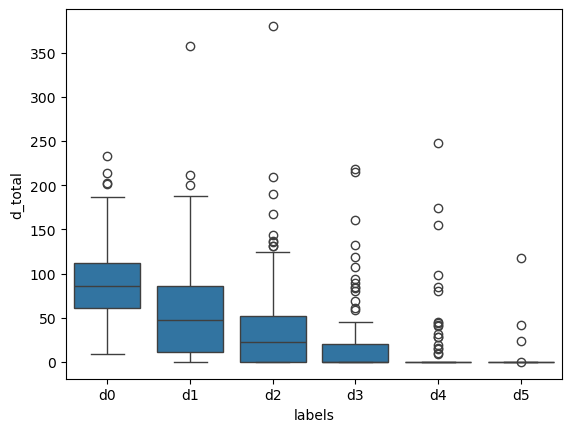

In [21]:
sns.boxplot(data = df_result_mg,x = 'labels', y = 'dx_total')

In [53]:
density_mg = np.asarray([53.000000,95.647059,113.352941,113.388889,88.187500,50.958333])/10


In [56]:
length_mg = df_result_mg.groupby('labels')['dx_total'].mean().values
length_mg

array([272.67584734, 358.68575637, 406.69913873, 430.15107071,
       525.0466937 , 218.76810429])

In [55]:
sum(density_mg * length_mg)

20108.456630727513

<AxesSubplot:xlabel='labels', ylabel='d_total'>

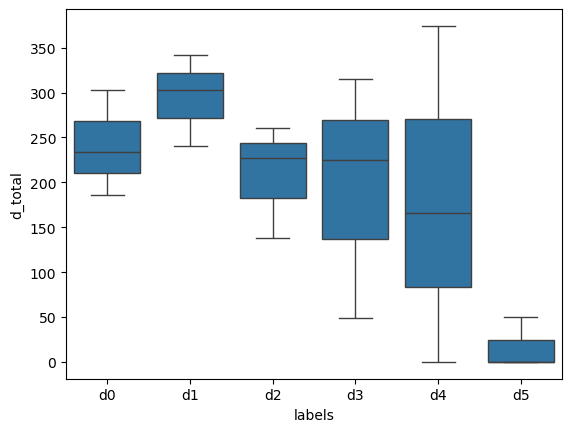

In [60]:
sns.boxplot(data = df_result_out,x = 'labels', y = 'dx_total')

In [63]:
density_out = np.asarray([38.647059,55.360000,64.944444,74.555556,63.800000,70.000000])/10

In [61]:
length_out = df_result_out.groupby('labels')['dx_total'].mean().values
length_out

array([241.03844701, 294.94504436, 208.80264752, 196.15481082,
       179.99711314,  16.54240193])

In [64]:
sum(density_out * length_out)

6647.037152368113

In [ ]:


# Define the y-range
y_min, y_max = 4, 10

# Function to calculate the path length for a subset of nodes
def calculate_path_length(G, nodes):
    subgraph = G.subgraph(nodes)
    total_length = 0
    for u, v in subgraph.edges():
        # Calculate edge length (Euclidean distance in 3D space)
        pos_u = subgraph.nodes[u]['pos']
        pos_v = subgraph.nodes[v]['pos']
        distance = sum((pos_u[i] - pos_v[i])**2 for i in range(3))**0.5
        total_length += distance
    return total_length

# Process each weakly connected component
for component in nx.weakly_connected_components(G):
    # Get the subset of nodes within the y-range
    nodes_in_range = [n for n in component if y_min <= G.nodes[n]['pos'][1] <= y_max]
    if nodes_in_range:
        path_length = calculate_path_length(G, nodes_in_range)
        print(f"Component {component} has path length {path_length:.2f} within the y-range.")

# Label nodes 

In [128]:
def find_closest_row(df, target_coords, multipliers=(128, 128, 120)):
    """
    Finds the row in the dataframe closest to the target coordinates after scaling.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'x', 'y', 'z', and 'rowId' columns.
        target_coords (tuple): Target coordinates (x, y, z) in original units.
        multipliers (tuple): Scaling factors for the coordinates (default is (16, 16, 30)).

    Returns:
        pd.Series: The row with the closest coordinates, including the rowId.
    """
    # Scale the target coordinates
    target_scaled = tuple(coord * multiplier for coord, multiplier in zip(target_coords, multipliers))
    
    # Calculate Euclidean distance to the target for each row
    df['distance'] = np.sqrt(
        (df['x'] - target_scaled[0])**2 +
        (df['y'] - target_scaled[1])**2 +
        (df['z'] - target_scaled[2])**2
    )
    
    # Find the closest row
    closest_row = df.loc[df['distance'].idxmin()]
    
    return closest_row #int(closest_row['rowId'])

def find_downstream_nodes_exclude_root(G, start_node, root_node):
    """
    Finds all downstream nodes from a given node, excluding those with paths containing the root node.

    Parameters:
        G (networkx.DiGraph): The directed graph.
        start_node (int): The node ID to start the search from.
        root_node (int): The root node to exclude from paths.

    Returns:
        list: A list of downstream node IDs that do not contain the root node in their paths.
    """
    if not G.has_node(start_node):
        raise ValueError(f"Start node {start_node} does not exist in the graph.")
    if not G.has_node(root_node):
        raise ValueError(f"Root node {root_node} does not exist in the graph.")
    
    # Perform depth-first search to find all reachable nodes
    all_downstream_nodes = list(nx.dfs_preorder_nodes(G, source=start_node))
    
    # Filter out nodes that have a path passing through the root node
    valid_nodes = []
    for node in all_downstream_nodes:
        if node == start_node:
            continue  # Skip the starting node itself
        paths_to_node = nx.all_simple_paths(G, source=start_node, target=node)
        # Check if any path includes the root node
        if not any(root_node in path for path in paths_to_node):
            valid_nodes.append(node)
    
    return valid_nodes

def find_downstream_nodes_all_paths_exclude_root(G, start_node, root_node, terminal_nodes):
    """
    Finds all nodes downstream of a given node in all paths, excluding those with paths containing the root node.

    Parameters:
        G (networkx.DiGraph): The directed graph.
        start_node (int): The node ID to start the search from.
        root_node (int): The root node to exclude from paths.

    Returns:
        list: A list of all downstream node IDs that do not contain the root node in their paths.
    """
    if not G.has_node(start_node):
        raise ValueError(f"Start node {start_node} does not exist in the graph.")
    if not G.has_node(root_node):
        raise ValueError(f"Root node {root_node} does not exist in the graph.")
    
    # List to store valid downstream nodes
    valid_downstream_nodes = set()

    valid_downstream_nodes = set()
    # Iterate through all nodes in the graph to find paths from start_node
    for node in terminal_nodes: #G.nodes:
        # Get all simple paths from start_node to node (if reachable)
        for path in nx.all_simple_paths(G, source=start_node, target=node):
            # If the path does not contain the root node, add the target node
            if root_node not in path:
                # valid_downstream_nodes.add(node)
                valid_downstream_nodes.update(path)
                break  # No need to check further paths to this node, since we found a valid one

    return list(valid_downstream_nodes)


def find_terminal_nodes(G):
    """
    Finds all terminal nodes in a directed graph (nodes with no outgoing edges).
    
    Parameters:
        G (networkx.DiGraph): The directed graph.
    
    Returns:
        list: A list of terminal node IDs (nodes with no outgoing edges).
    """
    return [node for node in G.nodes() if G.out_degree(node) == 0]

In [348]:
# all_paths = nx.all_simple_paths(G, source=start_node, target=terminal_nodes[10])

# nodes_in_paths = set()
# edges_in_paths = set()

# for path in all_paths:
#     print(path)
#     nodes_in_paths.update(path)
#     edges_in_paths.update(zip(path[:-1], path[1:]))

## neuprint swc to DataFrame

In [143]:
skelfile = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc/'
cell_folder = 'lf_393325331_mip3' #sg2_387415866_crude_mip3.swc'

In [144]:
df = npskel.skeleton_swc_to_df(f'{skelfile}{cell_folder}.swc')

df.loc[:,'node_type']=0

In [145]:
npskel.reorient_skeleton(df,use_max_radius=True)

In [146]:
df.sort_values('radius')

,rowId,x,y,z,radius,link,node_type
0,1,205120.0,90176.0,93660.0,120.000000,2,0
9231,9232,272064.0,312128.0,34380.0,120.000000,9231,0
9227,9228,272448.0,311872.0,34620.0,120.000000,9227,0
9226,9227,272576.0,311872.0,34620.0,120.000000,9226,0
9225,9226,272704.0,311872.0,34620.0,120.000000,9225,0
...,...,...,...,...,...,...,...
7214,7215,278464.0,304064.0,62820.0,4817.488281,7214,0
7223,7224,277440.0,304448.0,61860.0,4821.717773,7223,0
7213,7214,278336.0,304064.0,62940.0,4824.955078,7213,0
7220,7221,277824.0,304320.0,62100.0,4828.084473,7220,0


## df to iGraph to find nodes in paths without root

In [147]:
G = npskel.skeleton_df_to_nx(df, with_attributes=True, directed=True, with_distances=True, virtual_roots=False)
G = G.reverse()

In [148]:
terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

In [149]:
df[df['link'].isin([-1])]

,rowId,x,y,z,radius,link,node_type
7212,7213,278336.0,304064.0,63060.0,4835.389648,-1,0


In [150]:
df.loc[df['link'].isin([-1]),'node_type'] = 1

In [ ]:

'''
axon:lg (2329, 2162, 293) lf (2205, 2405, 576) mg2 (1683, 2026, 231) sg2(1517, 2152, 562) mg1 (2364, 1935, 379)
basal dendrite: lg (2298, 2175, 313), (2307, 2167, 303), (2326, 2187, 311), (2371, 2181, 309), (2289, 2164, 345), (2360, 2194, 411) lf (2116, 2402, 520), (2164, 2410, 479), (2193, 2406, 487), (2154, 2417, 533), (2215, 2437, 556)/    mg2(1677, 2114, 298) sg2(1491, 2154, 520) mg1 (2368, 2052, 403)
apical dendrite: lg (2390, 2104, 408), (2404, 2097, 374), (2339, 2092, 399), (2307, 2097, 372) lf(2175, 2287, 530) mg2(1703, 1972, 280) sg2(1473, 2070, 543) mg1 (2380, 1943, 412) (2418, 1941, 335)
'''


In [158]:
root_node = df[df['link'].isin([-1])]['rowId'].values[0]
target_coords =[(2175, 2287, 530)]

valid_nodes_all = []
for coords in target_coords:
    closest_row = efish.find_closest_row(df, coords, multipliers = (128,128,120))

    start_node = int(closest_row['rowId'])  # Replace with your starting node
    valid_downstream_nodes = efish.find_downstream_nodes_all_paths_exclude_root(G, start_node, root_node,terminal_nodes)
    valid_nodes_all.extend(valid_downstream_nodes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 436/436 [01:23<00:00,  5.19it/s]


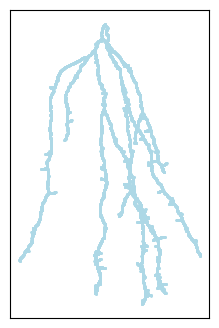

In [159]:
# Extract the subgraph for the branch
branch_subgraph = G.subgraph(valid_nodes_all)
pos = {node: (branch_subgraph.nodes[node]['x'], branch_subgraph.nodes[node]['y']) for node in valid_nodes_all} #G.nodes}

# Draw the branch subgraph
plt.figure(figsize=(5,4))
nx.draw_networkx_nodes(branch_subgraph, pos, node_color='lightblue', node_size=1) #, edge_color='gray', with_labels=False
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

In [160]:
'''
1: soma
2: axon
3: basal dendrite
4: apical dendrite
'''

df.loc[df['rowId'].isin(valid_nodes_all),'node_type'] = 4

In [161]:
df = df.sort_values('link')

## back to cloudvolume skel format

In [162]:
df.head()

,rowId,x,y,z,radius,link,node_type,distance
7212,7213,278336.0,304064.0,63060.0,4835.389648,-1,1,11341.044044
0,1,205120.0,90176.0,93660.0,120.000000,2,4,217495.093241
1,2,205248.0,90176.0,93540.0,120.000000,3,4,217435.443955
2,3,205376.0,90304.0,93420.0,120.000000,4,4,217256.649113
3,4,205504.0,90432.0,93300.0,120.000000,5,4,217077.924294


### cv-derived functions to reorder after root change

In [163]:
from collections import defaultdict

# def to_swc(self, contributors=""):

def render_row(row):
  return "{n} {T} {x:0.6f} {y:0.6f} {z:0.6f} {R:0.6f} {P}".format(
    n=row[0],
    T=row[1],
    x=row[2],
    y=row[3],
    z=row[4],
    R=row[5],
    P=row[6],
  )

# skels = self.components()
def renumber(rows):
  mapping = { -1: -1 }
  N = 1
  for row in rows:
    node = row[0]
    if node in mapping:
      row[0] = mapping[node]
      continue
    else:
      row[0] = N
      mapping[node] = N
      N += 1

  for row in rows:
    row[-1] = mapping[row[-1]]

  return rows

### initialize swc string

In [164]:
"""
Prototype SWC file generator. 
The SWC format was first defined in 

R.C Cannona, D.A Turner, G.K Pyapali, H.V Wheal. 
"An on-line archive of reconstructed hippocampal neurons".
Journal of Neuroscience Methods
Volume 84, Issues 1-2, 1 October 1998, Pages 49-54
doi: 10.1016/S0165-0270(98)00091-0
This website is also helpful for understanding the format:
https://web.archive.org/web/20180423163403/http://research.mssm.edu/cnic/swc.html
Returns: swc as a string
"""
from cloudvolume import __version__
# sx, sy, sz = np.diag(self.transform)[:3]
swc_header = f"""# ORIGINAL_SOURCE CloudVolume modified scripts 11.1.1
# CREATURE 
# REGION
# FIELD/LAYER
# TYPE
# CONTRIBUTOR kperks
# REFERENCE
# RAW 
# EXTRAS 
# SOMA_AREA
# SHINKAGE_CORRECTION 
# SCALE don't know how to get from dataframe yet 
"""
# VERSION_DATE {datetime.datetime.utcnow().isoformat()}
#SCALE {sx:.6f} {sy:.6f} {sz:.6f}

# skels = skel.components()
swc = swc_header + "\n"
offset = 0
# for skel in skels:
#   swc += generate_swc(skel, offset) + "\n"

### extract rows to list from DataFrame

In [165]:
all_rows = []
# Iterate over each row
for index, r in df.iterrows():
    # Create list for the current row
    row_list =[int(r.rowId), int(r.node_type), r.x, r.y, r.z, r.radius, int(r.link)]
    # append the list to the final list
    all_rows.append(row_list)

### renumber rows needed due to root node change

In [166]:
all_rows = renumber(all_rows)

In [167]:
all_rows[0:4]

[[1, 1, 278336.0, 304064.0, 63060.0, 4835.3896484375, -1],
 [2, 4, 205120.0, 90176.0, 93660.0, 120.0, 3],
 [3, 4, 205248.0, 90176.0, 93540.0, 120.0, 4],
 [4, 4, 205376.0, 90304.0, 93420.0, 120.0, 5]]

### add rows to swc string

In [168]:
swc += "\n".join((
  render_row(row)
  for row in all_rows
))

# return swc

### CloudVolume Skeleton from swc string

In [169]:
# skel = Skeleton.from_swc(skelfile_labeled)

lines = swc.split("\n")

while len(lines) and (lines[0] == '' or re.match(r'[#\s]', lines[0][0])):
  l = lines.pop(0)

if len(lines) == 0:
  # return Skeleton()
    skel_fromswc = Skeleton()

vertices = []
edges = []
radii = []
vertex_types = []

label_index = {}

N = 0

for line in lines:
  if line.replace(r"\s", '') == '':
    continue
  (vid, vtype, x, y, z, radius, parent_id) = line.split(" ")
  
  coord = tuple([ float(_) for _ in (x,y,z) ])
  vid = int(vid)
  parent_id = int(parent_id)

  label_index[vid] = N

  if parent_id >= 0:
    if vid < parent_id:
      edge = [vid, parent_id]
    else:
      edge = [parent_id, vid]

    edges.append(edge)

  vertices.append(coord)
  vertex_types.append(int(vtype))

  try:
    radius = float(radius)
  except ValueError:
    radius = -1 # e.g. radius = NA or N/A

  radii.append(radius)

  N += 1

for edge in edges:
  edge[0] = label_index[edge[0]]
  edge[1] = label_index[edge[1]]

In [170]:
skel_fromswc = Skeleton(vertices, edges, radii, vertex_types)

In [171]:
skel_fromswc

Skeleton(segid=None, vertices=(shape=19500, float32), edges=(shape=19499, uint32), radius=(19500, float32), vertex_types=(19500, uint8), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])

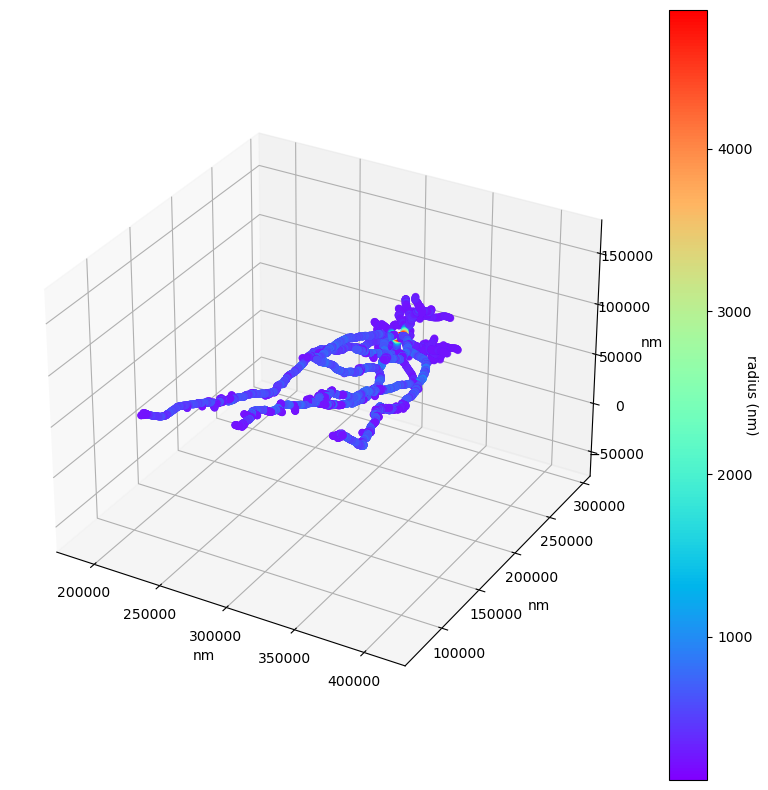

In [41]:
skel_fromswc.viewer()

### export swc from Skeleton

In [172]:
swc_outfile = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc')

In [173]:
cell_folder = 'lf_393325331_mip3_maincomponent_labeled'

In [174]:
# Step 4: Write the SWC data to a file
with open(swc_outfile / f'{cell_folder}.swc', 'w') as swc_file:
    swc_file.write(skel_fromswc.to_swc())

# location in VAST from local

In [167]:
local_loc = (2252, 2271, 164) #x,y,z
local_offset = (9792*16/128, 1920*16/128, 0)
local_res = (128,128,120)
VAST_res = (16,16,30)


VAST_loc = [(l)*r/v for l,o,r,v in zip(local_loc,local_offset,local_res,VAST_res)]

VAST_loc

[18016.0, 18168.0, 656.0]

In [ ]:
1484, 2080, 641
1558, 2174, 664
1692, 2227, 536
1573, 2194, 465
1598, 2212, 396
1667, 2249, 389
1483, 2207, 477
1587, 2209, 359

# OBJ from Local Mesh CloudVolume retrieve http

In [1]:
import trimesh

In [10]:
vol = CloudVolume('precomputed://http://localhost:8001')

In [11]:
mesh= vol.mesh.get(299496636)

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 10/13 [00:02<00:00,  3.98it/s]WARNING:urllib3.connectionpool:Connection pool is full, discarding connection: localhost. Connection pool size: 10

Decoding Mesh Buffer: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1522.26it/s]


In [12]:
reduction_ratio = 0.2

scale_factor = 100000
yaxis_replace_scale = 32768*16/scale_factor
# zaxis_replace_scale = 3534*30/scale_factor
refpt = [0,0,0]

In [13]:
vertices = mesh.vertices
vertices = vertices/scale_factor
vertices = [[v[0]-refpt[0],v[1]-refpt[1],v[2]-refpt[2]] for i,v in enumerate(vertices)]
vertices = [[v[0],yaxis_replace_scale-v[1],v[2]] for v in vertices]
faces = mesh.faces
trimesh_mesh = trimesh.Trimesh(vertices=vertices, faces=faces,process=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.95it/s]


In [17]:
# downsample the fused mesh before joining to the fused_mesh and exporting as a .obj for blender
simplified_mesh = trimesh_mesh.simplify_quadric_decimation(face_count=len(trimesh_mesh.vertices) * reduction_ratio)


In [14]:
trimesh_mesh.export(Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/ms/figures_final/blender/obj/Fig5') / 'mg1_299496636.obj');

# visualize specific segments in neuroglancer from local precomputed


In [ ]:
def get_viewer(backgnd_color = "white"):
    viewer = neuroglancer.Viewer()
    viewer.set_state({})

    location=[2062,1349,400]

    with viewer.config_state.txn() as s:
        s.show_layer_panel = True ###

    with viewer.txn(overwrite=True) as s:

        dimensions = neuroglancer.CoordinateSpace(
            scales=[128,128,120],#vx_sizes,# self.vx_sizes['em'],
            units='nm',
            names=['x', 'y', 'z']   )

        s.showSlices = False
        s.dimensions = dimensions
        s.position = np.asarray(location)
        s.layout = "3d"
        s.projectionScale = 30000
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]#"#000000"
        # s.projection_background_color= "#ffffff"
        s.showSlices = False

    with viewer.txn(overwrite=True) as s:
        wb_open(str(viewer))
    
    return viewer

def create_em_layer(viewer, source = 'brainmaps://10393113184:ell:roi450um_xyz'):
    with viewer.txn(overwrite=True) as s:
        s.layers['em'] = neuroglancer.ImageLayer(source = source)

def create_baseseg_layer(viewer, source, lname, visible = False, objectAlpha = 1):
    with viewer.txn(overwrite=True) as s:
        s.layers[lname] = neuroglancer.SegmentationLayer(source = source, segments=[], segment_colors={})
        s.layers[lname].ignoreNullVisibleSet = False
        s.layers[lname].pick = True
        s.layers[lname].selectedAlpha = 0.5 #For 2D
        s.layers[lname].objectAlpha = objectAlpha
        s.layers[lname].visible = visible

In [220]:
viewer = get_viewer()

In [229]:
source = 'precomputed://http://localhost:8000'
lname='SG_in-sub-vol'

create_baseseg_layer(viewer, source, lname)

In [230]:
vol = CloudVolume(source)

In [231]:
segIDs_all = vol.unique(bbox=vol.bounds) - set([0]) # get all segment IDs in volume and remove segment ID 0, which is background

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████| 562/562 [00:04<00:00, 118.98it/s]


In [233]:
'''all segments to the same tab  '''  

for i,c_id in enumerate(segIDs_all):
    # if df_type[df_type['id']==int(c_id)]['cell_type'].values[0] == 'mli':
    # lname = c_id + '_' + df_type[df_type['id']==int(c_id)]['cell_type'].values[0]#cell.get_ctype('manual')
    
    with viewer.txn(overwrite=True) as s:
        s.layers[lname].segments.add(int(c_id))
    # sleep(2)